# Retrieval Methods Tutorial

This notebook demonstrates various retrieval methods for RAG systems using vector databases. Each method serves different use cases and has specific advantages.

## 📚 Overview of Methods

1. **Basic Similarity Search** - Standard semantic search
2. **MMR (Maximal Marginal Relevance)** - Balance relevance and diversity
3. **Score Thresholding** - Quality-based filtering
4. **Adaptive/Dynamic Retrieval** - Flexible result counts
5. **Metadata Filtering** - Context-aware search
6. **Document Chunk Linking** - Multi-document retrieval
7. **LLM-Guided Filtering** - Intelligent pre-filtering
8. **Reranking** - Reorder results for higher precision  
9. **Hybrid Retrieval** - Combine keyword and semantic search  



## 🔧 Setup


In [1]:
from collections import Counter
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, Filter, FieldCondition, MatchValue, MatchText
from retrieval_playground.utils import config, constants
from retrieval_playground.utils.model_manager import model_manager
from retrieval_playground.src.pre_retrieval.chunking_strategies import ChunkingStrategy
from langchain.prompts import PromptTemplate
from typing import Dict, List, Any
import json

import logging
logging.getLogger().setLevel(logging.WARNING)

In [2]:
# Load test queries
def load_test_queries() -> List[Dict[str, Any]]:
    """Load test queries from JSON file."""
    queries_path = config.TESTS_DIR / "test_queries.json"
    with open(queries_path, 'r') as f:
        return json.load(f)

test_queries = load_test_queries()
sample_query = test_queries[0]["user_input"]
print(f"Sample query: {sample_query}")


Sample query: How does MC3G improve upon existing counterfactual explanation methods, particularly concerning cost computation and causal dependencies?


In [3]:
# Setup vector database
strategy = ChunkingStrategy.UNSTRUCTURED
qdrant_client = QdrantClient(url=constants.QDRANT_URL, api_key=constants.QDRANT_KEY)
embeddings = model_manager.get_embeddings()

vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=strategy.value,
    embedding=embeddings
)

print("✅ Vector store initialized")


2025-09-18 20:14:26.523 INFO model_manager - _initialize_models: 🔄 ModelManager: Initializing shared AI models...


2025-09-18 20:14:26,523 - INFO - 🔄 ModelManager: Initializing shared AI models...


2025-09-18 20:14:33.879 INFO model_manager - _initialize_models: ✅ ModelManager: Shared AI models initialized successfully


2025-09-18 20:14:33,879 - INFO - ✅ ModelManager: Shared AI models initialized successfully


✅ Vector store initialized


In [4]:
# Common parameters
TOP_K = 3
SCORE_THRESHOLD = 0.5


## 1. Basic Similarity Search

**What it is:**  Standard cosine similarity between query and document embeddings.

**When to use:**
- Default choice for most RAG applications
- When you need the most semantically similar content
- Simple, fast, and reliable

**✅ Pros:** Fast, simple, works well for most cases  
**⚠️ Cons:** May return very similar/duplicate content


In [5]:
# Basic similarity search with scores
context_docs_with_score = vector_store.similarity_search_with_relevance_scores(
    sample_query, k=TOP_K
)

print("📊 Similarity Search Results:")
for i, (doc, score) in enumerate(context_docs_with_score, 1):
    print(f"{i}. Score: {score:.3f} | Source: {doc.metadata['source']} | ChunkID: {doc.metadata['chunk_id']} ")
    print(f"   Preview: {doc.page_content[:50].strip()}...\n")

📊 Similarity Search Results:
1. Score: 0.916 | Source: Analytics_2025_MC3G__Model_Agnostic_Causally_Constrained_Counterfactual_Generation.pdf | ChunkID: 64ab7c14-a35a-4d58-846c-c0562c91c111 
   Preview: Cars

6. Conclusion and Future Work In this paper,...

2. Score: 0.910 | Source: Analytics_2025_MC3G__Model_Agnostic_Causally_Constrained_Counterfactual_Generation.pdf | ChunkID: f8328dda-95ac-4243-afd8-1e233f5d8e4b 
   Preview: 3.2. MC3G Approach MC3G defines two distinct state...

3. Score: 0.903 | Source: Analytics_2025_MC3G__Model_Agnostic_Causally_Constrained_Counterfactual_Generation.pdf | ChunkID: 0ed01265-aeea-4eb1-8a74-951aeb822b89 
   Preview: Causally Compliant Causal Consistency (%)

FALSE I...



## 2. MMR (Maximal Marginal Relevance)

**What it is:**  Balances relevance with diversity to avoid near-duplicate results.

**Formula:** `score = λ * similarity(query, doc) – (1 – λ) * max(similarity(doc, selected_docs))`

**When to use:**
- When documents have repetitive/similar content
- Need diverse perspectives on the same topic
- Quality over quantity approach

**✅ Pros:** Reduces redundancy, increases content diversity  
**⚠️ Cons:** May miss highly relevant but similar content

In [6]:
# MMR search
query_embedding = embeddings.embed_query(sample_query)
mmr_docs_with_score = vector_store.max_marginal_relevance_search_with_score_by_vector(
    embedding=query_embedding, k=TOP_K
)

print("MMR Search Results:\n")
for i, (doc, score) in enumerate(mmr_docs_with_score, 1):
    print(f"{i}. MMR Score: {score:.3f} | Source: {doc.metadata['source']} | ChunkID: {doc.metadata['chunk_id']} ")
    print(f"   Preview: {doc.page_content[:50]}...\n")

MMR Search Results:

1. MMR Score: 0.833 | Source: Analytics_2025_MC3G__Model_Agnostic_Causally_Constrained_Counterfactual_Generation.pdf | ChunkID: 64ab7c14-a35a-4d58-846c-c0562c91c111 
   Preview: Cars

6. Conclusion and Future Work In this paper,...

2. MMR Score: 0.429 | Source: Analytics_2025_Graph-R1__Incentivizing_the_Zero-Shot_Graph_Learning_Capability_in_LLMs___via_Ex.pdf | ChunkID: a28cf9c3-9ab2-493e-9a6a-65b32e1e4638 
   Preview: Content

Calculate the chemical relevant propertie...

3. MMR Score: 0.403 | Source: Statistics_2025_Copas-Jackson-type_bounds_for_publication_bias_over_a_general_class_of___selecti.pdf | ChunkID: 6c302b0b-ce7c-46cc-b37e-095543928f2a 
   Preview: Marginal selection probability

Figure 1. Variatio...



In [7]:
print("\n🔍 Comparison:")
print("Similarity sources:", [doc[0].metadata['chunk_id'] for doc in context_docs_with_score])
print("MMR sources:       ", [doc[0].metadata['chunk_id'] for doc in mmr_docs_with_score])



🔍 Comparison:
Similarity sources: ['64ab7c14-a35a-4d58-846c-c0562c91c111', 'f8328dda-95ac-4243-afd8-1e233f5d8e4b', '0ed01265-aeea-4eb1-8a74-951aeb822b89']
MMR sources:        ['64ab7c14-a35a-4d58-846c-c0562c91c111', 'a28cf9c3-9ab2-493e-9a6a-65b32e1e4638', '6c302b0b-ce7c-46cc-b37e-095543928f2a']


In [8]:
del context_docs_with_score, query_embedding, mmr_docs_with_score

## 3. Dynamic / Adaptive Thresholds

**What it is:**  Only return results above a minimum relevance score.

**When to use:**
- Quality control - avoid irrelevant results
- When "no answer" is better than a bad answer
- Variable-length result sets based on quality

**✅ Pros:** Ensures quality, filters noise  
**⚠️ Cons:** May return no results for difficult queries

In [9]:
# Score thresholding with fixed k
context_docs_with_score = vector_store.similarity_search_with_relevance_scores(
    sample_query, k=TOP_K
)

retriever_with_threshold = vector_store.as_retriever(
    search_kwargs={"k": TOP_K, "score_threshold": SCORE_THRESHOLD}
)
threshold_docs = retriever_with_threshold.invoke(sample_query)

print(f"📏 Score Threshold Results (min score: {SCORE_THRESHOLD}):")
print(f"Found {len(threshold_docs)} documents above threshold")

# Compare with scores
all_scores = [score for _, score in context_docs_with_score]
above_threshold = [score for score in all_scores if score >= SCORE_THRESHOLD]

print(f"All scores: {all_scores}")
print(f"Above threshold ({SCORE_THRESHOLD}): {above_threshold}")


📏 Score Threshold Results (min score: 0.5):
Found 3 documents above threshold
All scores: [0.9163227700000001, 0.91010773, 0.90327715]
Above threshold (0.5): [0.9163227700000001, 0.91010773, 0.90327715]


In [10]:
# Score thresholding with fixed k -  With scores
# Test with different queries to show variability
print("\n📊 Results for different queries:")
for i, query_data in enumerate(test_queries[:3], 1):
    query = query_data["user_input"]
    docs =  vector_store.similarity_search_with_relevance_scores(query, k=TOP_K)
    scores = [round(doc[1],2) for doc in docs]
    print(f"Query {i}: {len(docs)} results |  Scores: {scores} | Topic: {query[:50]}...")


📊 Results for different queries:
Query 1: 3 results |  Scores: [0.92, 0.91, 0.9] | Topic: How does MC3G improve upon existing counterfactual...
Query 2: 3 results |  Scores: [0.79, 0.77, 0.77] | Topic: What limitations of the Copas-Jackson bound did th...
Query 3: 3 results |  Scores: [0.89, 0.87, 0.86] | Topic: What is the key innovation of the proposed Riemann...


In [11]:
del context_docs_with_score, retriever_with_threshold, threshold_docs, all_scores, above_threshold

## 4. Dynamic/Adaptive Retrieval

**What it is:**  Variable number of results based only on score threshold (no fixed k).

**When to use:**
- Query difficulty varies widely
- Want all relevant content above a quality bar
- Adaptive context length for LLM processing

**✅ Pros:** Flexible result count, quality-focused  
**⚠️ Cons:** Unpredictable context length, potential cost implications


In [12]:
# Dynamic retrieval (no fixed k)
dynamic_retriever = vector_store.as_retriever(
    search_kwargs={"score_threshold": SCORE_THRESHOLD}
)
dynamic_docs = dynamic_retriever.invoke(sample_query)

print(f"🔄 Dynamic Retrieval Results:")
print(f"Found {len(dynamic_docs)} documents above threshold {SCORE_THRESHOLD}")

# Test with different queries to show variability
print("\n📊 Results for different queries:")
for i, query_data in enumerate(test_queries[:3], 1):
    query = query_data["user_input"]
    docs = dynamic_retriever.invoke(query)
    print(f"Query {i}: {len(docs)} results | Topic: {query[:50]}...")

🔄 Dynamic Retrieval Results:
Found 4 documents above threshold 0.5

📊 Results for different queries:
Query 1: 4 results | Topic: How does MC3G improve upon existing counterfactual...
Query 2: 4 results | Topic: What limitations of the Copas-Jackson bound did th...
Query 3: 4 results | Topic: What is the key innovation of the proposed Riemann...


In [13]:
del dynamic_retriever, dynamic_docs

## 5. Metadata Filtering

**What it is:**  Filter search results by document metadata (source, type, date, etc.).

**When to use:**
- Domain-specific searches (e.g., only medical papers)
- Time-based filtering (recent documents only)
- Source credibility filtering
- User permission-based access control

**✅ Pros:** Precise targeting, context control  
**⚠️ Cons:** May miss relevant content from filtered sources


In [14]:
from qdrant_client.http import models as rest

qdrant_client.create_payload_index(
    collection_name="unstructured",
    field_name="metadata.source",
    field_schema=rest.PayloadSchemaType.TEXT
)

UpdateResult(operation_id=51, status=<UpdateStatus.COMPLETED: 'completed'>)

In [15]:
# Example 1: Exact source match
target_file = "Statistics_2025_Copas-Jackson-type_bounds_for_publication_bias_over_a_general_class_of___selecti.pdf"

exact_filter_retriever = vector_store.as_retriever(
    search_kwargs={
        "k": TOP_K,
        "filter": Filter(
            must=[
                FieldCondition(
                    key="metadata.source",  
                    match=MatchText(text=target_file)
                )
            ]
        )
    }
)

exact_filtered_docs = exact_filter_retriever.invoke(sample_query)
print(f"🎯 Exact Source Filter Results:")
print(f"Target: {target_file[:50]}...")
print(f"Found {len(exact_filtered_docs)} results from this source")

🎯 Exact Source Filter Results:
Target: Statistics_2025_Copas-Jackson-type_bounds_for_publ...
Found 3 results from this source


In [16]:
# Example 2: Substring/topic-based filtering
topic_filter_retriever = vector_store.as_retriever(
    search_kwargs={
        "k": TOP_K,
        "filter": Filter(
            must=[
                FieldCondition(
                    key="metadata.source", 
                    match=MatchText(text="Statistics_2025")  # substring match
                )
            ]
        )
    }
)

topic_filtered_docs = topic_filter_retriever.invoke(sample_query)
print(f"\n📊 Topic Filter Results (Statistics papers):")
print(f"Found {len(topic_filtered_docs)} results")
for doc in topic_filtered_docs:
    print(f"- {doc.metadata['source'][:60]}...")


📊 Topic Filter Results (Statistics papers):
Found 3 results
- Statistics_2025_Copas-Jackson-type_bounds_for_publication_bi...
- Statistics_2025_Alternative_statistical_inference_for_the_fi...
- Statistics_2025_Alternative_statistical_inference_for_the_fi...


In [17]:
del target_file, exact_filter_retriever, exact_filtered_docs, topic_filter_retriever, topic_filtered_docs

## 6. Document Chunk Linking

**What it is:**  First find relevant documents, then retrieve more chunks from those same documents.

**When to use:**
- When relevant info might be spread across chunks in same document
- Want comprehensive coverage of relevant documents
- Building document-level understanding

**✅ Pros:** Comprehensive document coverage, maintains context  
**⚠️ Cons:** May include less relevant chunks from relevant documents


In [18]:
# Step 1: Find most relevant documents
initial_docs = vector_store.similarity_search(sample_query, k=2)
relevant_sources = [doc.metadata["source"] for doc in initial_docs]

print(f"🔗 Document Chunk Linking:")
print(f"Step 1 - Found relevant documents:")
for source in relevant_sources:
    print(f"- {source[:60]}...")

# Step 2: Get more chunks from these documents
linked_retriever = vector_store.as_retriever(
    search_kwargs={
        "k": TOP_K,
        "filter": Filter(
            should=[  # OR condition across multiple files
                FieldCondition(
                    key="metadata.source",
                    match=MatchText(text=source)
                )
                for source in relevant_sources
            ]
        )
    }
)

linked_docs = linked_retriever.invoke(sample_query)
print(f"\nStep 2 - Retrieved {len(linked_docs)} total chunks from relevant documents")

# Show distribution
source_counts = Counter([doc.metadata['source'] for doc in linked_docs])
for source, count in source_counts.items():
    print(f"- {count} chunks from {source[:50]}...")


🔗 Document Chunk Linking:
Step 1 - Found relevant documents:
- Analytics_2025_MC3G__Model_Agnostic_Causally_Constrained_Cou...
- Analytics_2025_MC3G__Model_Agnostic_Causally_Constrained_Cou...

Step 2 - Retrieved 3 total chunks from relevant documents
- 3 chunks from Analytics_2025_MC3G__Model_Agnostic_Causally_Const...


In [19]:
del initial_docs, relevant_sources, linked_retriever, linked_docs, source_counts

## 7. LLM-Guided Filtering 

**What it is:**  Use an LLM to classify queries and route to appropriate filtered retrievers.

**When to use:**
- Multi-domain knowledge bases
- Complex query understanding needed
- When simple keyword filtering isn't sufficient
- Domain-specific optimization

**✅ Pros:** Intelligent routing, domain optimization  
**⚠️ Cons:** Added LLM call overhead, potential classification errors


In [20]:
# Setup LLM for query classification
llm = model_manager.get_llm()

TOPIC_IDENTIFICATION_TEMPLATE = PromptTemplate(
    input_variables=["query"],
    template="""
Classify the query into one of two topics:

- "Computer_Vision": if related to image/video processing, recognition, detection, segmentation, or OCR.  
- "Other": for everything else.  

Return only the class name.  

Query: {query}  
Topic:
"""
)

def classify_query(query: str) -> str:
    """Classify query into Computer_Vision or Other."""
    category = llm.invoke(
        TOPIC_IDENTIFICATION_TEMPLATE.format(query=query)
    ).content.strip()
    return category

def get_retriever(category: str, k: int = TOP_K):
    """Return retriever based on classification."""
    if category == "Computer_Vision":
        print("🎯 Using Computer Vision filtered retriever\n")
        return vector_store.as_retriever(
            search_kwargs={
                "k": k,
                "filter": Filter(
                    must=[
                        FieldCondition(
                            key="metadata.source", 
                            match=MatchText(text="Computer_Vision")
                        )
                    ]
                )
            }
        )
    else:
        print("🔍 Using general retriever\n")
        return vector_store.as_retriever(
            search_kwargs={"k": k, "score_threshold": SCORE_THRESHOLD}
        )

# -------------------
# Testing
# -------------------
print("🧪 Testing LLM-Guided Filtering:\n")
llm_filtering_queries = [test_queries[i] for i in [0, 3]]  
for i, query in enumerate(llm_filtering_queries, 1):
    q_text = query["user_input"]
    expected = "Computer_Vision" if "Computer_Vision" in query["source_file"] else "Other"

    print(f"\n📋 Test {i}: {q_text[:150]}")

    predicted = classify_query(q_text)
    print(f"🤖 Predicted: {predicted} | Expected: {expected}")

    result = "Correctly Classified ✅" if predicted == expected else "Incorrectly Classified ❌"
    print(result)

🧪 Testing LLM-Guided Filtering:


📋 Test 1: How does MC3G improve upon existing counterfactual explanation methods, particularly concerning cost computation and causal dependencies?
🤖 Predicted: Other | Expected: Other
Correctly Classified ✅

📋 Test 2: What are the key challenges in adapting existing open-vocabulary semantic segmentation (OVSS) frameworks, designed for natural images, to remote sensi
🤖 Predicted: Computer_Vision | Expected: Computer_Vision
Correctly Classified ✅


In [21]:
del llm, TOPIC_IDENTIFICATION_TEMPLATE, llm_filtering_queries

## 8. Reranking

**What it is:**  
Applies a secondary model (e.g., cross-encoder, LLM, or relevance model) to reorder initial retrieval results, improving relevance ranking beyond similarity scores alone.  

**When to use:**   
- Dense or hybrid retrieval gives many candidates but order matters  
- Need **higher precision** in the top results (e.g., top-3 for RAG context)  
- Queries where subtle semantic nuances are important  

**✅ Pros:**   
- Improves relevance of top results  
- Reduces noise passed to the LLM  
- Works well with hybrid/similarity search as a post-processing step  

**⚠️ Cons:**   
- Higher latency and compute cost  
- Requires additional model training or fine-tuning for best results  
- May not scale well for very large candidate sets  

**Example use case:**  
- Initial retriever returns 20 (>>K) research paper abstracts.  
- A cross-encoder reranker re-scores them, surfacing the **most directly relevant Top-K** for the query context.  


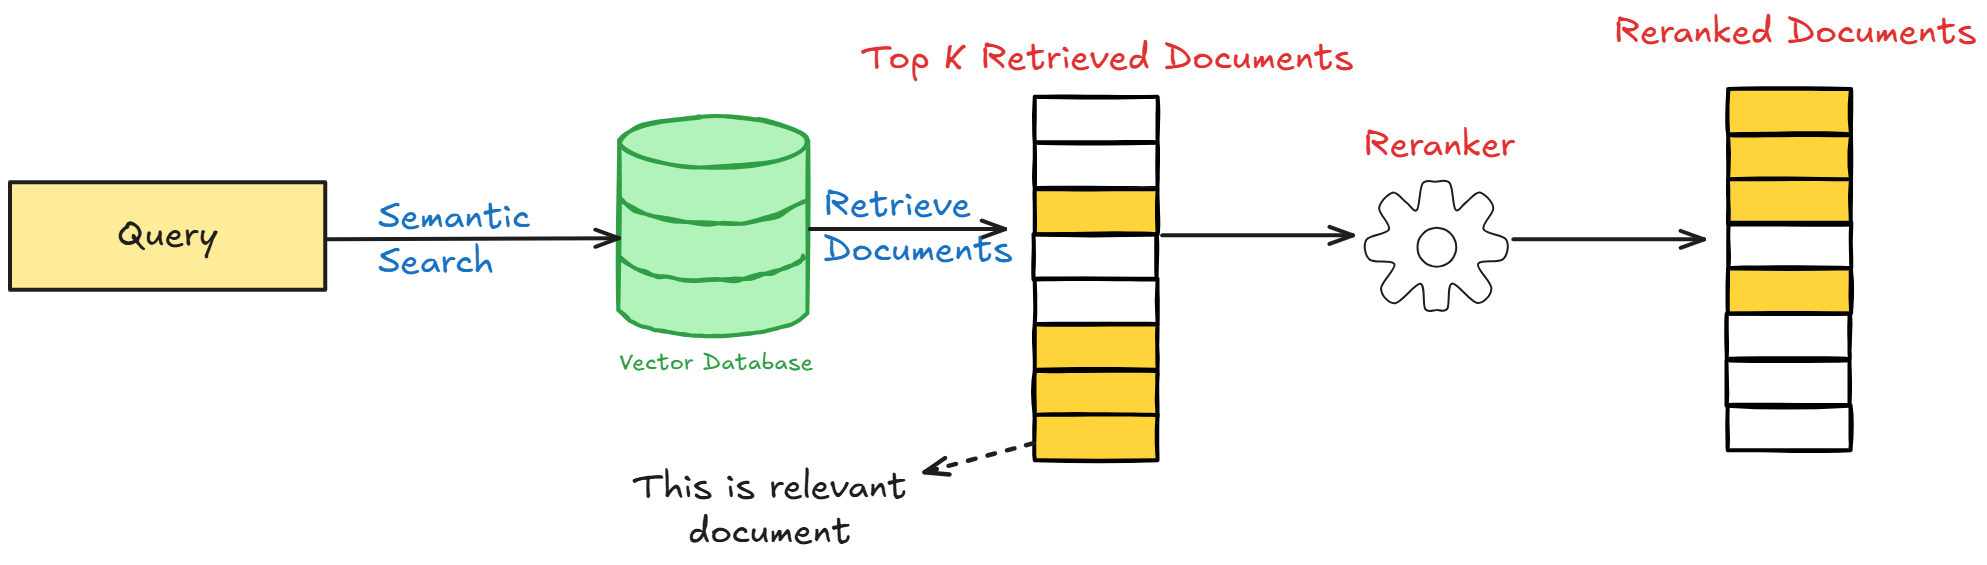

In [22]:
from IPython.display import Image, display
display(Image(filename="../../utils/images/reranking.png"))

In [23]:
# Refer reranking.py 
def _setup_reranker_retriever():
    """Initialize the reranking retriever."""
    qdrant_path = config.QDRANT_DIR / strategy.value
    qdrant_client = QdrantClient(path=str(qdrant_path))
    embeddings = model_manager.get_embeddings()

    vector_store = QdrantVectorStore(
        client=qdrant_client,
        collection_name=strategy.value,
        embedding=embeddings,
    )

    retriever = vector_store.as_retriever(search_kwargs={"k": top_k})

    model = HuggingFaceCrossEncoder(model_name=constants.RERANKER_MODEL)
    compressor = CrossEncoderReranker(model=model, top_n=top_n)
    reranker_retriever = ContextualCompressionRetriever(
        base_compressor=compressor, base_retriever=retriever
    )
    return reranker_retriever

In [24]:
from retrieval_playground.src.mid_retrieval.reranking import Reranker
reranker = Reranker(qdrant_client=qdrant_client, top_n=TOP_K)
reranker_evaluation_results = reranker.evaluate_reranking()

✅ Reranker initialized
Starting reranking evaluation...
Evaluating 5 test queries

Query 1: How does MC3G improve upon existing counterfactual explanation methods, particularly concerning cost...
  Result 1: Reranker=0.923, Baseline=0.746
  Result 2: Reranker=0.793, Baseline=0.690
  Result 3: Reranker=0.657, Baseline=0.656
  📊 Query avg: Reranker=0.791, Baseline=0.697

Query 2: What limitations of the Copas-Jackson bound did the authors identify, and how did they address these...
  Result 1: Reranker=0.852, Baseline=0.863
  Result 2: Reranker=0.843, Baseline=0.803
  Result 3: Reranker=0.863, Baseline=0.852
  📊 Query avg: Reranker=0.853, Baseline=0.839

Query 3: What is the key innovation of the proposed Riemannian change point detection method, and how does it...
  Result 1: Reranker=0.664, Baseline=0.777
  Result 2: Reranker=0.777, Baseline=0.634
  Result 3: Reranker=0.915, Baseline=0.664
  📊 Query avg: Reranker=0.785, Baseline=0.692

Query 4: What are the key challenges in adapting e

In [25]:
del reranker, reranker_evaluation_results

## 9. Hybrid Filtering

**What it is:**   
Combines sparse retrieval (BM25/keyword-based) with dense retrieval (embeddings-based) to leverage both exact keyword matching and semantic similarity.

**How it works:**  
- BM25 ensures keyword precision (great for rare terms, acronyms, or exact matches).  
- Dense retrieval ensures semantic recall (captures meaning even if words differ).  
- Final results are combined (via weighted scores, reranking, or union).  

**When to use:**  
- Queries with a mix of rare keywords and semantic intent  
- Domain-specific content with technical jargon (BM25 helps catch exact terms)  
- General RAG pipelines where coverage + precision both matter  
- When neither sparse nor dense alone gives consistently good results  

**✅ Pros:** Best of both worlds – exact match + semantic understanding  
**⚠️ Cons:** More complex to implement, higher compute cost  

**Example use case:**  

*Query:*  
*“What are the key challenges in adapting existing open-vocabulary semantic segmentation (OVSS) frameworks, designed for natural images, to remote sensing images, and how does SegEarth-OV address these challenges?”*  

*BM25 (Sparse)*: Catches exact terms - *“semantic segmentation”*, *“open-vocabulary”*, *“remote sensing”*, *OVSS*  

*Dense (Semantic)*: Finds paraphrases - *“pixel-level classification for satellite imagery”*, *“domain adaptation from natural to aerial scenes”*, *“generalized segmentation across modalities”*  

*Hybrid*: Returns both - keyword-heavy matches (*“open-vocabulary segmentation for remote sensing”*) + semantic ones (*“SegEarth-OV enables cross-domain satellite segmentation”*).  

*Result:* Covers **precision (keywords)** + **recall (semantic similarity)**.  


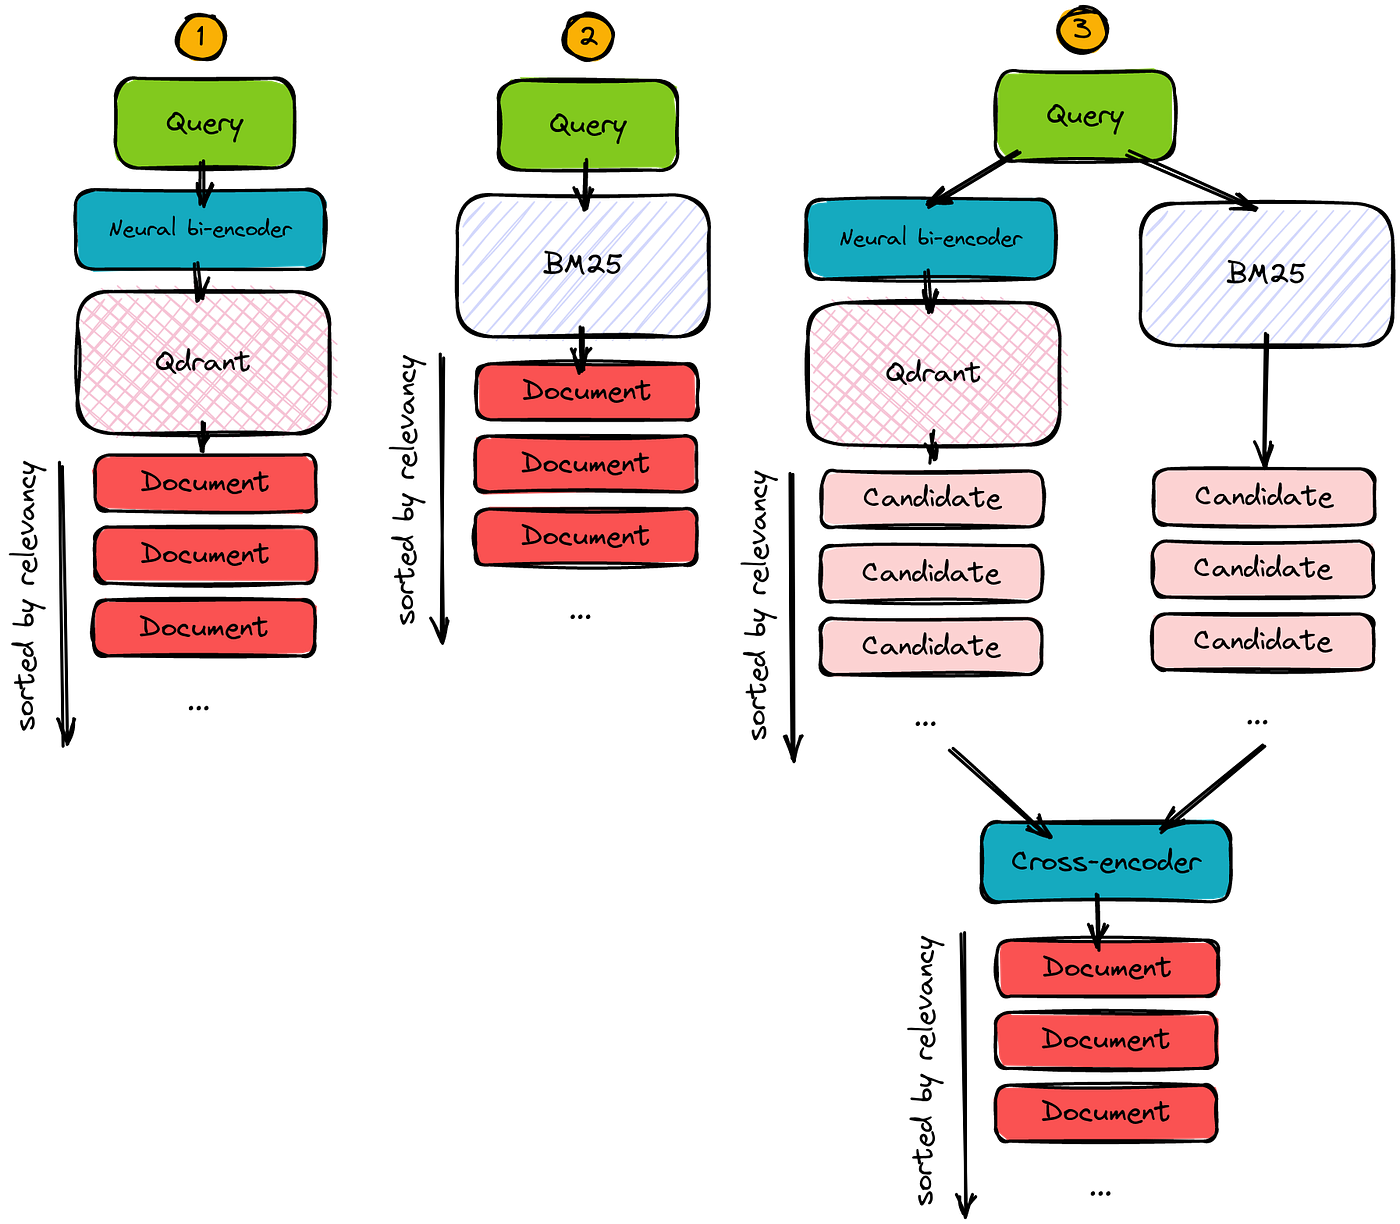

In [26]:
from IPython.display import Image, display
display(Image(filename="../../utils/images/hybrid_search.png"))

```python
from qdrant_client import QdrantClient, models
from qdrant_client.models import PointStruct, SparseVector, NamedVector, NamedSparseVector, SearchRequest
from sentence_transformers import SentenceTransformer
from splade.models.transformer import Splade
import torch

# ----------------------------
# 1. Setup Qdrant client
# ----------------------------
client = QdrantClient(url={url})

collection = {add_collection_name}

# Create collection with dense + sparse configs
client.recreate_collection(
    collection_name=collection,
    vectors_config={"text_dense": models.VectorParams(size=768, distance=models.Distance.COSINE)},
    sparse_vectors_config={"text_sparse": models.SparseVectorParams()}
)

# ----------------------------
# 2. Load embedding models
# ----------------------------
dense_model = SentenceTransformer({DENSE_EMBEDDING})   # Dense embeddings
sparse_model = Splade("naver/splade-cocondenser-ensembledistil")  # Sparse embeddings

# ----------------------------
# 3. Collection Update: Insert example documents
# ----------------------------
docs = [
    "Estimating treatment effect in cluster randomized trials",
    "Neural networks for computer vision tasks",
    "Advancements in generative AI and LLMs"
]

points = []
for i, text in enumerate(docs):
    dense_vec = dense_model.encode(text).tolist()
    with torch.no_grad():
        sparse_out = sparse_model(text)
    indices = sparse_out.indices.tolist()
    values = sparse_out.values.tolist()

    points.append(
        PointStruct(
            id=i,
            payload={"text": text},
            vector={
                "text_dense": dense_vec,
                "text_sparse": SparseVector(indices=indices, values=values),
            },
        )
    )

client.upsert(collection_name=collection, points=points)

# ----------------------------
# 4. Query Input
# ----------------------------
query = input("Enter your query: ")

# Dense vector
query_dense = dense_model.encode(query).tolist()

# Sparse vector
with torch.no_grad():
    sparse_out = sparse_model(query)
query_sparse = SparseVector(
    indices=sparse_out.indices.tolist(),
    values=sparse_out.values.tolist()
)

# ----------------------------
# 5. Hybrid Search (Batch)
# ----------------------------
response = client.search_batch(
    collection_name=collection,
    requests=[
        SearchRequest(vector=NamedVector(name="text_dense", vector=query_dense), limit=5),
        SearchRequest(vector=NamedSparseVector(name="text_sparse", vector=query_sparse), limit=5),
    ]
)

dense_results, sparse_results = response

# ----------------------------
# 6. Fuse Results (Reciprocal Rank Fusion)
# ----------------------------
combined_scores = {}

for rank, res in enumerate(dense_results):
    combined_scores[res.id] = combined_scores.get(res.id, 0) + 1 / (60 + rank)
for rank, res in enumerate(sparse_results):
    combined_scores[res.id] = combined_scores.get(res.id, 0) + 1 / (60 + rank)

fused_results = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

# ----------------------------
# 7. Print Results
# ----------------------------
print("\n🔎 Hybrid Search Results:")
for doc_id, score in fused_results:
    print(f"Score: {score:.4f} | Text: {docs[doc_id]}")
```

## 📋 Method Comparison & Recommendations

### Quick Comparison Table

| Method | Best For | Pros | Cons | Complexity |
|--------|----------|------|------|------------|
| **Similarity Search** | General purpose | Fast, simple, reliable | May return duplicates | Low |
| **MMR** | Diverse content | Reduces redundancy | May miss similar relevant content | Medium |
| **Score Threshold** | Quality control | Ensures minimum quality | May return no results | Low |
| **Dynamic Retrieval** | Variable content needs | Flexible, quality-focused | Unpredictable context length | Low |
| **Metadata Filtering** | Domain-specific | Precise targeting | May miss cross-domain insights | Medium |
| **Chunk Linking** | Document comprehension | Comprehensive coverage | Less relevant chunks included | Medium |
| **LLM-Guided** | Multi-domain systems | Intelligent routing | LLM overhead, classification errors | High |
| **Hybrid Retrieval (BM25 + Dense)** | Balanced semantic + keyword search | Captures both exact matches & semantic meaning | Requires tuning weight between BM25 & dense | High |
| **Reranking** | Precision in top results | Improves top-k relevance, reduces noise | Higher latency & compute cost | High |

---

### 🎯 Recommendations

#### **Start Simple**
Begin with **Similarity Search + Score Threshold** for most applications.

#### **Scale Up Based on Needs**
- Add **MMR** if you notice repetitive results  
- Use **Metadata Filtering** for multi-domain knowledge bases  
- Implement **LLM-Guided Filtering** for complex routing needs  
- Adopt **Hybrid Retrieval (BM25 + Dense)** when queries require both exact keyword matches (e.g., specific terms, codes) and semantic understanding (contextual intent)  
- Add **Reranking** when you need **high precision in the top results** (e.g., top-3 context for LLMs)  

#### **Fine-tuning Tips**
- Adjust `score_threshold` based on your quality requirements (0.3–0.5 is typical)  
- Use **Dynamic Retrieval** when context length flexibility is valuable  
- Apply **Chunk Linking** for document-centric tasks  
- Tune the BM25 vs Dense weighting in **Hybrid Retrieval** (common ranges: 0.3–0.7) depending on whether precision (keywords) or recall (semantics) is more important  
- Use **Reranking** selectively on top-N candidates to balance cost vs accuracy  

#### **Pro Tips**
- Monitor retrieval metrics (precision, recall) to choose optimal methods  
- Consider combining methods (e.g., MMR + Score Threshold, Hybrid + Reranking)  
- Cache LLM classification results for repeated query patterns  
- A/B test different approaches with your specific use case  
- Start with simple methods and add complexity only when needed  

#### **Common Patterns**
- **High-quality RAG**: Similarity Search + Score Threshold + MMR  
- **Multi-domain KB**: LLM-Guided Filtering + Metadata Filtering  
- **Document Analysis**: Chunk Linking + Score Threshold  
- **Exploratory Search**: Dynamic Retrieval + MMR  
- **Balanced Search (keyword + meaning)**: Hybrid Retrieval (BM25 + Dense) + Score Threshold  
- **High-precision Context**: Hybrid Retrieval + Reranking  

#### ✅ Tutorial completed! You now know 9 different retrieval methods.
🚀 Ready to build better RAG systems!

Next steps:
- Experiment with different methods on your own data
- Combine methods for optimal results
- Monitor and evaluate retrieval quality
- Scale complexity based on your specific needs
